In [2]:
import dataset
import torch
import matplotlib.pyplot as plt

from utils import DepthNorm
from losses import ssim, depth_loss
from mobilenetv3 import MobileNetSkipConcat
device = (
        "cuda"
        if torch.cuda.is_available()
        else "mps"
        if torch.backends.mps.is_available()
        else "cpu"
    )
print(f"Now using device: {device}")

print("Loading data ...")
train_loader, val_loader = dataset.createTrainLoader("./data.zip", samples=10, batch_size=4)
test_loader = dataset.createTestLoader("./data.zip", batch_size=1)

print("DataLoaders now ready ...")
model = MobileNetSkipConcat().to(torch.device(device))

Now using device: cuda
Loading data ...
Loading dataset zip file...Loaded (50688).
Training set size: 8  Validation set size: 2
Loading dataset zip file...Loaded (50688).
DataLoaders now ready ...


In [3]:
checkpoint = torch.load('checkpoints/epoch_100.pt')
model.load_state_dict(checkpoint['model_state_dict'])
l1_criterion = torch.nn.L1Loss()

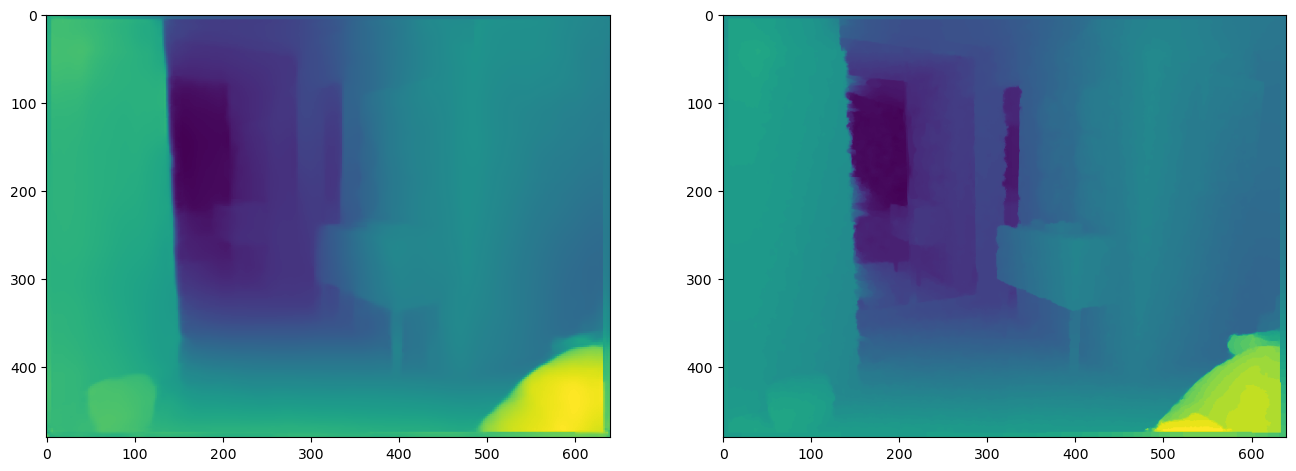

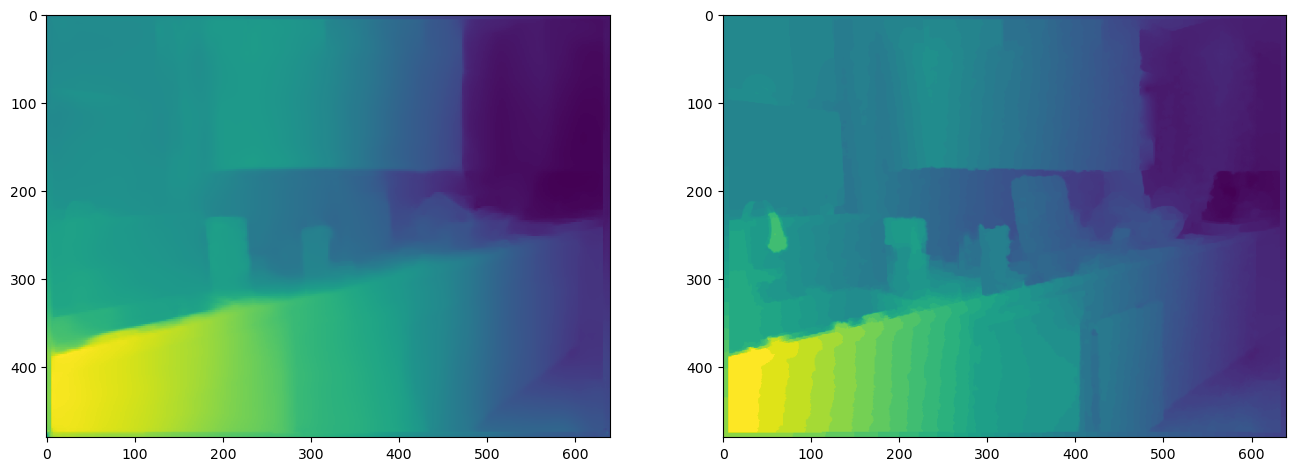

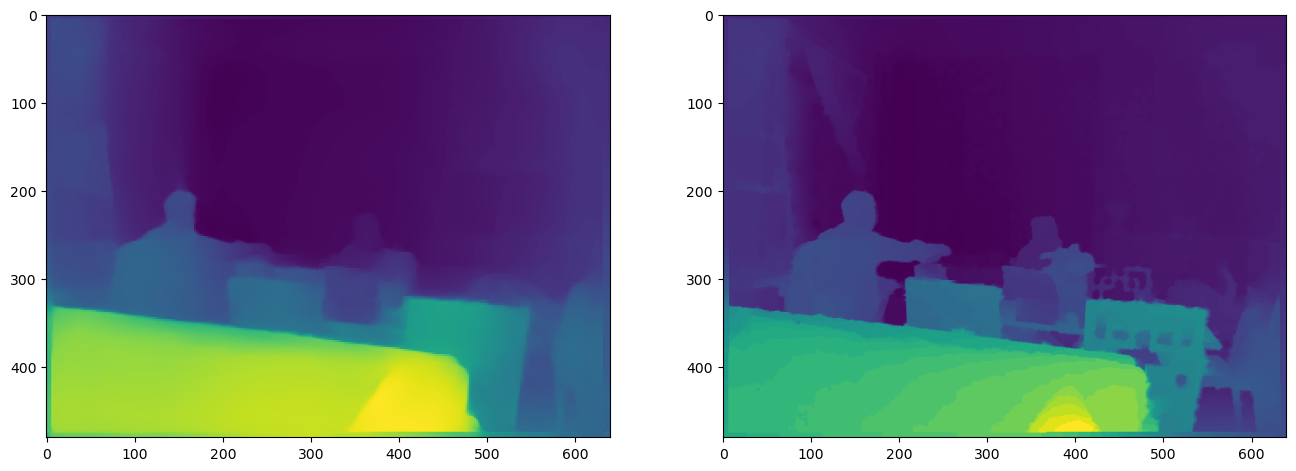

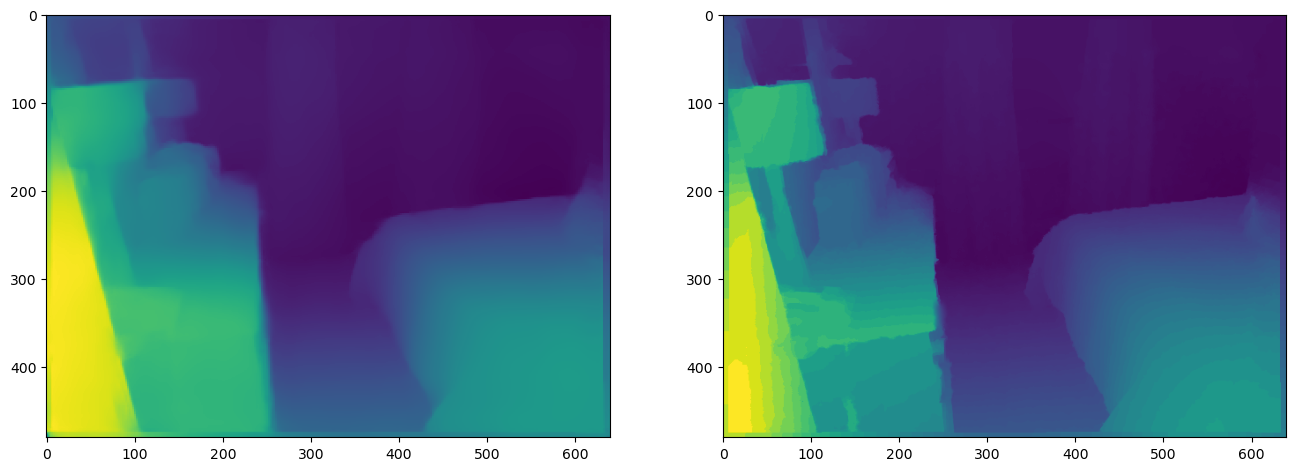

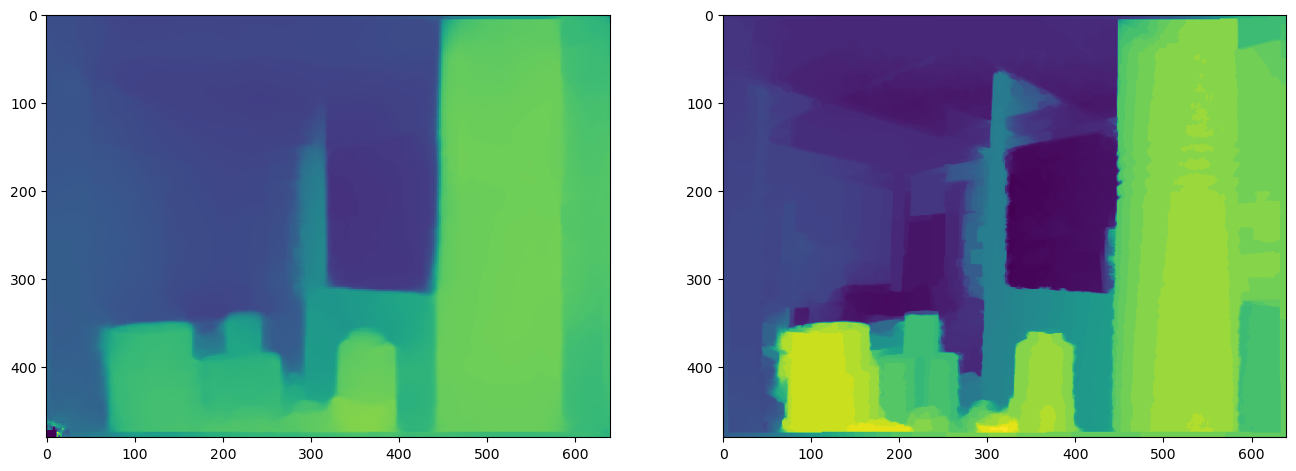

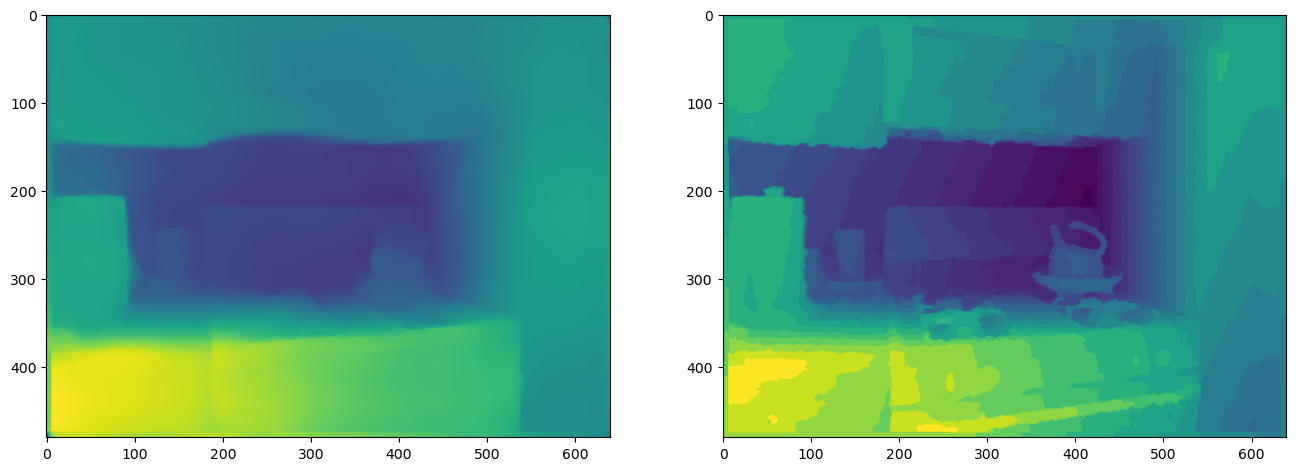

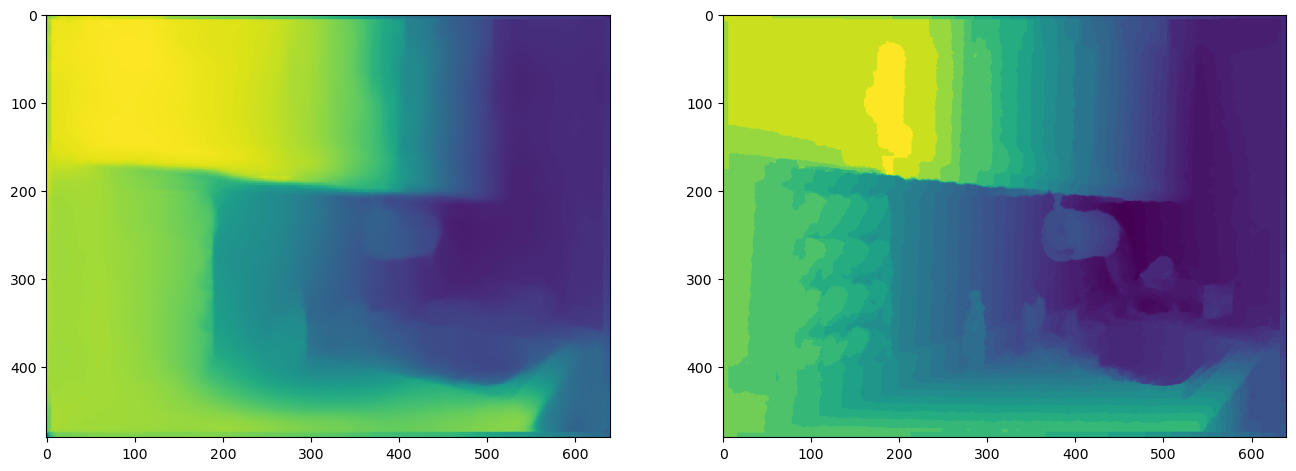

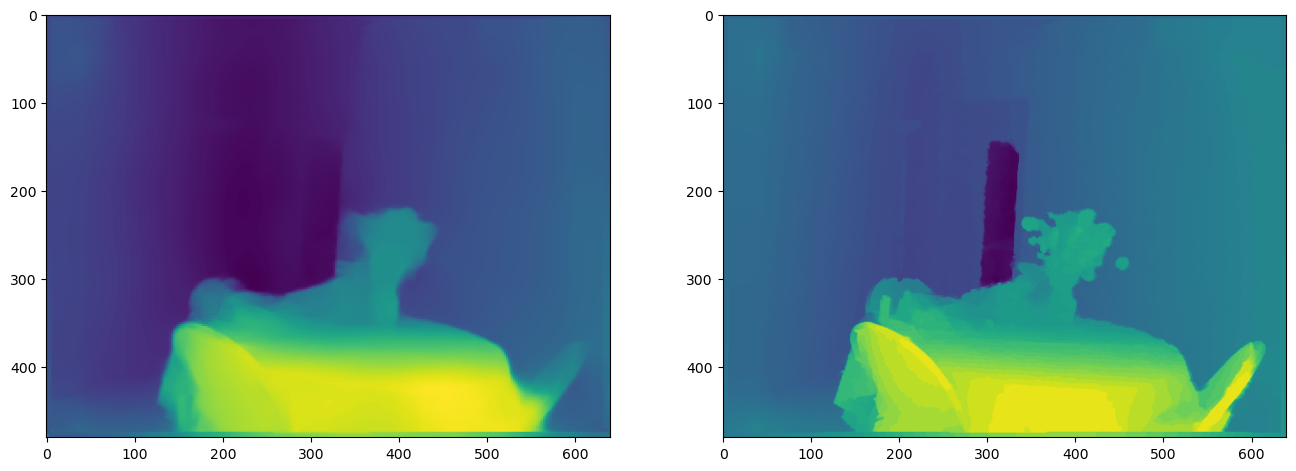

In [11]:
model.eval()
with torch.no_grad():
    running_test_loss = 0
    for batch_idx, batch in enumerate(test_loader):
        image = torch.Tensor(batch["image"]).to(device)
        depth = torch.Tensor(batch["depth"]).to(device)

        normalized_depth = DepthNorm(depth)

        pred = model(image)
        
        # out = DepthNorm(pred)
        
        error_pred = pred.cpu().detach().squeeze(0)
        error_depth = normalized_depth.cpu().detach().squeeze(0)
        
        fig,ax = plt.subplots(1,2,figsize=(16,8))
        ax[0].imshow(error_pred.permute(1,2,0))
        ax[1].imshow(error_depth.permute(1,2,0))
        
        if (batch_idx >= 7):
            break
        


In [12]:
from torchsummary import summary
summary(model, (3, 640, 480), device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 320, 240]             432
       BatchNorm2d-2         [-1, 16, 320, 240]              32
         Hardswish-3         [-1, 16, 320, 240]               0
            Conv2d-4         [-1, 16, 320, 240]             144
       BatchNorm2d-5         [-1, 16, 320, 240]              32
              ReLU-6         [-1, 16, 320, 240]               0
            Conv2d-7         [-1, 16, 320, 240]             256
       BatchNorm2d-8         [-1, 16, 320, 240]              32
  InvertedResidual-9         [-1, 16, 320, 240]               0
           Conv2d-10         [-1, 64, 320, 240]           1,024
      BatchNorm2d-11         [-1, 64, 320, 240]             128
             ReLU-12         [-1, 64, 320, 240]               0
           Conv2d-13         [-1, 64, 160, 120]             576
      BatchNorm2d-14         [-1, 64, 1

In [ ]:
totals

{'abs_rel': tensor(121.1369),
 'sq_rel': tensor(46269.3789),
 'rmse': tensor(354.7513),
 'rmse_log': tensor(5.2986),
 'a1': tensor(0.),
 'a2': tensor(0.),
 'a3': 0.0}

In [16]:
from tqdm import tqdm

def test(model, dataloader, criterion, device, epoch, train=False):
    model.eval()  
    running_loss = 0.0
    errors = []
    l1_loss = torch.nn.L1Loss()
    with torch.no_grad():  
        # for images, depths in tqdm(dataloader):
        for samples in tqdm(dataloader):
            images, targets = samples['image'], samples['depth']
            images, targets = images.to(device), targets.to(device)
            # Forward pass
            predictions = model(images)
            errors.append(compute_errors(targets, predictions))
    epoch_loss = running_loss / len(dataloader.dataset)
    # Convert list of tuples to a list of tensors
    error_tensors = [torch.tensor(e).to(device) for e in errors]
    # Stack the list of tensors along a new dimension
    error_stack = torch.stack(error_tensors, dim=0)
    # Compute the mean of each error metric across all batches
    mean_errors = error_stack.mean(0).cpu().numpy()
    # Index into mean_errors to get each metric
    abs_rel = mean_errors[0]
    sq_rel = mean_errors[1]
    rmse = mean_errors[2]
    rmse_log = mean_errors[3]
    a1 = mean_errors[4]
    a2 = mean_errors[5]
    a3 = mean_errors[6]
    print(f"Abs Rel: {abs_rel:.3f}, Sq Rel: {sq_rel:.3f}, RMSE: {rmse:.3f}, RMSE log {rmse_log:.3f}, d1: {a1:.3f}, d2: {a2:.3f}, d3: {a3:.3f}")
    
test(model, test_loader, torch.nn.L1Loss(), "cuda", 1)

100%|██████████| 500/500 [00:16<00:00, 30.01it/s]


Abs Rel: 0.977, Sq Rel: 286.220, RMSE: 313.760, RMSE log 4.239, d1: 0.000, d2: 0.000, d3: 0.000
